## Code Walkthrough: Multimodal Emotion Recognition

This script implements a comprehensive pipeline for recognizing human emotions from audio and text data, specifically using the RAVDESS dataset. Here's a breakdown of its operations:

1.  **Setup and Configuration:**
    *   Imports necessary libraries: `torch` for deep learning, `librosa` for audio, `whisper` for speech-to-text, `transformers` for BERT, `pandas` for data handling, `sklearn` for metrics, etc.
    *   Sets up the computation `DEVICE` (GPU if available, else CPU).
    *   Defines global configurations: dataset path (`RAVDESS_PATH`), audio processing parameters (sample rate, FFT size, Mel bands, duration), text processing parameters (max length), model training parameters (batch size, epochs, learning rates), and emotion mappings.
    *   Crucially, `USE_SIMULATED_SENTENCES` is set to `True`, meaning the text modality will primarily use predefined sentences corresponding to each emotion, rather than the limited original RAVDESS speech content for text modeling.

2.  **Data Loading and Preparation (`load_ravdess_data`):**
    *   Locates and parses audio files from the specified `RAVDESS_PATH`.
    *   Extracts emotion labels and actor IDs from filenames, filtering for audio-only speech.
    *   Handles cases where the dataset might not be found by providing an option to use dummy data for structural testing.
    *   Encodes emotion labels into numerical format using `LabelEncoder`.
    *   Splits the data into training, validation, and test sets using stratified splitting.

3.  **Transcript Generation/Selection (`get_or_simulate_transcripts`):**
    *   If `USE_SIMULATED_SENTENCES` is `True` (default): Assigns predefined, emotion-rich sentences to each audio sample based on its emotion label. This is done to provide meaningful lexical content for the text models.
    *   If `USE_SIMULATED_SENTENCES` is `False`: Uses OpenAI's `whisper` model (`tiny.en`) to transcribe audio files. Transcripts are cached to avoid re-processing.

4.  **Unimodal Pipeline - Audio CNN:**
    *   **Feature Extraction (`audio_to_spectrogram`):** Converts raw audio waves into Mel spectrograms. Ensures all spectrograms have a fixed duration and width by padding or truncating.
    *   **Dataset (`AudioDataset`):** Custom PyTorch `Dataset` to load and serve spectrograms and their labels.
    *   **Model (`AudioCNN`):** Defines a 2D Convolutional Neural Network designed to process spectrograms. It includes convolutional layers, batch normalization, ReLU activations, max pooling, and fully connected layers for classification. An `extract_features` method is included for later use in fusion.
    *   **Training & Evaluation:** The Audio CNN is trained using the `train_model_generic` function (with Adam optimizer and ReduceLROnPlateau scheduler) and evaluated using `evaluate_model_generic`. The best model weights are saved.

5.  **Unimodal Pipeline - Text RNN (LSTM):**
    *   **Tokenizer (`BasicTokenizer`):** A simple word-level tokenizer is created and fitted on the (simulated) training transcripts.
    *   **Dataset (`TextDataset`):** Custom PyTorch `Dataset` for tokenized text sequences and labels.
    *   **Model (`TextRNN`):** Defines an LSTM-based Recurrent Neural Network with an embedding layer, bidirectional LSTM layers, dropout, and a fully connected layer for classification. It also has an `extract_features` method.
    *   **Training & Evaluation:** Similar to the Audio CNN, the Text RNN is trained and evaluated, with its best weights saved.

6.  **Multimodal Fusion - Setup:**
    *   **Dataset (`MultimodalDataset`):** A custom PyTorch `Dataset` that provides paired audio spectrograms, tokenized text (adaptable for RNN or BERT tokenization), and emotion labels for training fusion models.

7.  **Multimodal Fusion - Early Fusion (with TextRNN features):**
    *   **Model (`EarlyFusionModel`):**
        *   Initializes with pre-trained (and frozen) Audio CNN and Text RNN feature extractors.
        *   Audio and text features are extracted, concatenated, and then passed through a new set of fully connected layers (fusion head) for classification.
    *   **Training & Evaluation (`train_early_fusion`, `evaluate_early_fusion`):** The fusion head of the `EarlyFusionModel` is trained using the `MultimodalDataset`. The best model weights are saved.

8.  **Multimodal Fusion - Late Fusion (with TextRNN features):**
    *   **Evaluation (`evaluate_late_fusion`):**
        *   Loads the best saved Audio CNN and Text RNN models.
        *   For each sample in the test set, obtains probability outputs from both unimodal models.
        *   Averages these probabilities to make a final emotion prediction.
        *   Calculates and reports the accuracy of this late fusion strategy.

9.  **Bonus Phase - Text Transformer (DistilBERT):**
    *   **Tokenizer & Model Loading:** Loads a pre-trained `distilbert-base-uncased` tokenizer and model (for sequence classification) from Hugging Face Transformers.
    *   **Dataset (`BertTextDataset`):** Custom PyTorch `Dataset` specifically for BERT, handling its tokenization requirements (special tokens, attention masks, padding).
    *   **Training & Evaluation:** The DistilBERT model is fine-tuned on the (simulated) text transcripts using `train_model_generic` (with AdamW optimizer) and `evaluate_model_generic`. Best weights are saved.

10. **Multimodal Fusion - Early Fusion (with TextBERT features):**
    *   **Feature Extractor for BERT (`BertFeatureExtractor`):** A wrapper class is defined to use the main BERT layers (excluding the classification head) of the fine-tuned `bert_text_model` as a feature extractor. It outputs the [CLS] token embedding.
    *   **Model (`EarlyFusionModel`):** A new instance is created, this time using the Audio CNN extractor and the `BertFeatureExtractor`.
    *   **Training & Evaluation:** The fusion head is trained similarly to the RNN-based early fusion, using the `MultimodalDataset` configured for BERT inputs.

11. **Multimodal Fusion - Late Fusion (with TextBERT features):**
    *   **Evaluation (`evaluate_late_fusion`):** Similar to the RNN late fusion, but uses the fine-tuned DistilBERT model alongside the Audio CNN for probability averaging.

12. **Results Summary and Reporting:**
    *   Collects test accuracies from all trained and evaluated models.
    *   Prints a final summary of these accuracies to the console.
    *   Attempts to generate a `.docx` report summarizing the dataset, configurations, and model performances using the `python-docx` library.


Using device: cuda
Loaded 1440 audio files from RAVDESS.
Emotion distribution:
emotion
calm         192
happy        192
angry        192
sad          192
disgust      192
surprised    192
fearful      192
neutral       96
Name: count, dtype: int64
Train samples: 979, Val samples: 173, Test samples: 288
Using simulated sentences based on emotion labels.
Using simulated sentences based on emotion labels.
Using simulated sentences based on emotion labels.
Using simulated sentences based on emotion labels.

Sample transcripts (potentially simulated):
        emotion                                 transcript
108     fearful  That sound was so scary, it made me jump!
201       happy                      I can't stop smiling!
112   surprised              Wow, I can't believe my eyes!
1250       calm              I feel so serene and relaxed.
655     fearful                A shiver ran down my spine.
Basic RNN Tokenizer vocab size: 153

--- Phase 1: Audio CNN Pipeline ---


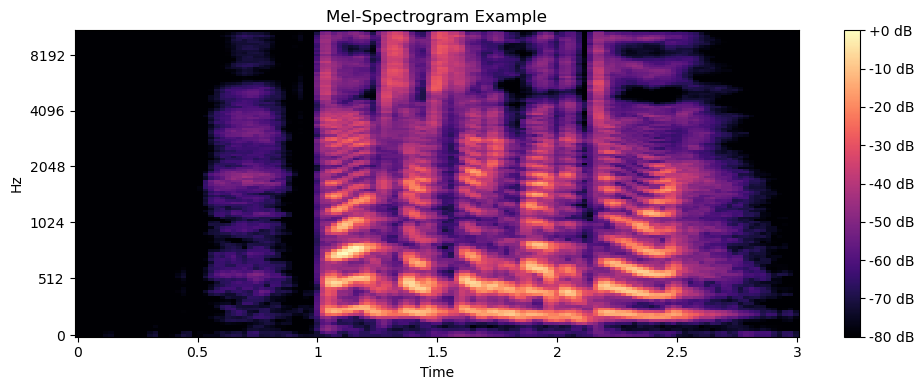


Training AudioCNN...
Epoch 1/15 - Train Loss: 1.9858, Acc: 0.2697 - Val Loss: 1.8202, Acc: 0.3353
Saved best model (AudioCNN) with Val Acc: 0.3353
Epoch 2/15 - Train Loss: 1.5456, Acc: 0.4147 - Val Loss: 1.4756, Acc: 0.4855
Saved best model (AudioCNN) with Val Acc: 0.4855
Epoch 3/15 - Train Loss: 1.2317, Acc: 0.5608 - Val Loss: 1.3697, Acc: 0.5087
Saved best model (AudioCNN) with Val Acc: 0.5087
Epoch 4/15 - Train Loss: 1.0149, Acc: 0.6537 - Val Loss: 1.2860, Acc: 0.5260
Saved best model (AudioCNN) with Val Acc: 0.5260
Epoch 5/15 - Train Loss: 0.7457, Acc: 0.7538 - Val Loss: 1.1764, Acc: 0.5723
Saved best model (AudioCNN) with Val Acc: 0.5723
Epoch 6/15 - Train Loss: 0.4769, Acc: 0.8754 - Val Loss: 1.2277, Acc: 0.5549
Epoch 7/15 - Train Loss: 0.3476, Acc: 0.9213 - Val Loss: 1.2341, Acc: 0.5318
Epoch 8/15 - Train Loss: 0.1907, Acc: 0.9714 - Val Loss: 1.1963, Acc: 0.6185
Saved best model (AudioCNN) with Val Acc: 0.6185
Epoch 9/15 - Train Loss: 0.0971, Acc: 0.9939 - Val Loss: 1.1213, Acc

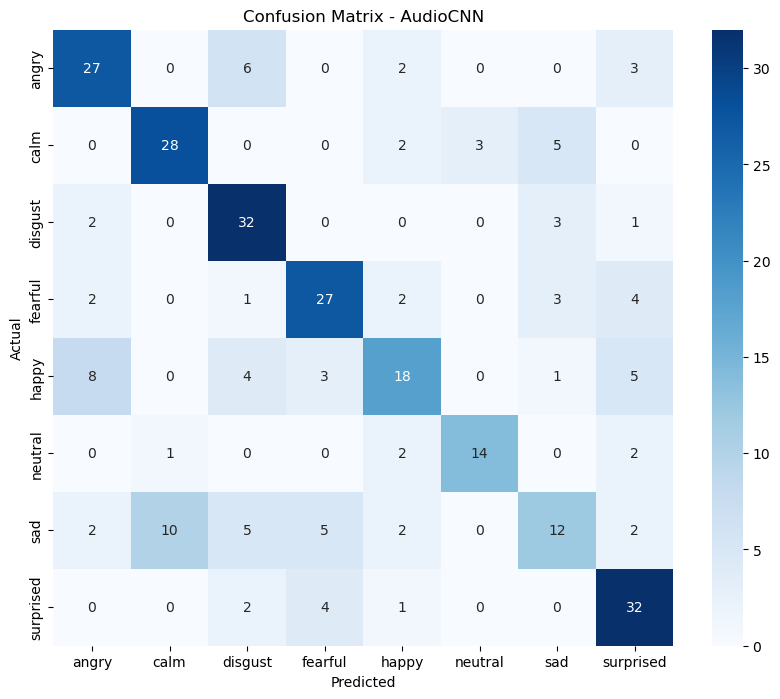


--- Phase 1: Text RNN Pipeline ---

Training TextRNN...
Epoch 1/10 - Train Loss: 2.0628, Acc: 0.2257 - Val Loss: 2.0494, Acc: 0.3237
Saved best model (TextRNN) with Val Acc: 0.3237
Epoch 2/10 - Train Loss: 2.0325, Acc: 0.4178 - Val Loss: 2.0214, Acc: 0.6185
Saved best model (TextRNN) with Val Acc: 0.6185
Epoch 3/10 - Train Loss: 2.0012, Acc: 0.6027 - Val Loss: 1.9865, Acc: 0.7572
Saved best model (TextRNN) with Val Acc: 0.7572
Epoch 4/10 - Train Loss: 1.9556, Acc: 0.7242 - Val Loss: 1.9366, Acc: 0.8266
Saved best model (TextRNN) with Val Acc: 0.8266
Epoch 5/10 - Train Loss: 1.8856, Acc: 0.8018 - Val Loss: 1.8531, Acc: 0.8613
Saved best model (TextRNN) with Val Acc: 0.8613
Epoch 6/10 - Train Loss: 1.7551, Acc: 0.8498 - Val Loss: 1.6669, Acc: 0.8671
Saved best model (TextRNN) with Val Acc: 0.8671
Epoch 7/10 - Train Loss: 1.4017, Acc: 0.8355 - Val Loss: 1.1373, Acc: 0.9133
Saved best model (TextRNN) with Val Acc: 0.9133
Epoch 8/10 - Train Loss: 0.8735, Acc: 0.9091 - Val Loss: 0.5940, Acc

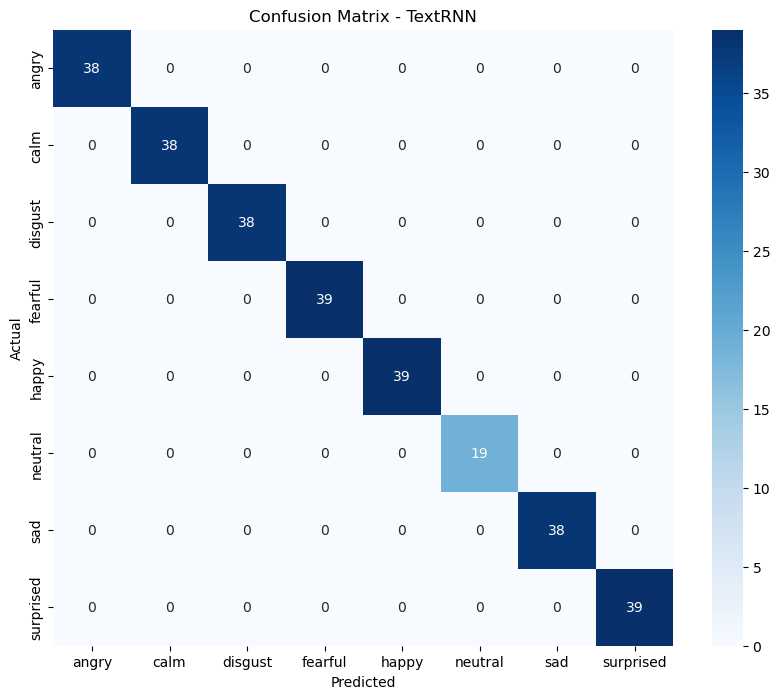


--- Phase 2: Fusion with TextRNN ---

Training EarlyFusion_RNN...
Epoch 1/10 - Train Loss: 1.6592, Acc: 0.5230 - Val Loss: 1.4443, Acc: 0.7861
Saved best model (EarlyFusion_RNN) with Val Acc: 0.7861
Epoch 2/10 - Train Loss: 0.8786, Acc: 0.9295 - Val Loss: 0.9934, Acc: 0.8324
Saved best model (EarlyFusion_RNN) with Val Acc: 0.8324
Epoch 3/10 - Train Loss: 0.4396, Acc: 0.9918 - Val Loss: 0.7212, Acc: 0.9075
Saved best model (EarlyFusion_RNN) with Val Acc: 0.9075
Epoch 4/10 - Train Loss: 0.2412, Acc: 0.9980 - Val Loss: 0.5812, Acc: 0.9017
Epoch 5/10 - Train Loss: 0.1504, Acc: 0.9980 - Val Loss: 0.4927, Acc: 0.9017
Epoch 6/10 - Train Loss: 0.0952, Acc: 1.0000 - Val Loss: 0.4318, Acc: 0.9133
Saved best model (EarlyFusion_RNN) with Val Acc: 0.9133
Epoch 7/10 - Train Loss: 0.0752, Acc: 1.0000 - Val Loss: 0.3930, Acc: 0.9133
Epoch 8/10 - Train Loss: 0.0549, Acc: 1.0000 - Val Loss: 0.3605, Acc: 0.9191
Saved best model (EarlyFusion_RNN) with Val Acc: 0.9191
Epoch 9/10 - Train Loss: 0.0435, Acc:

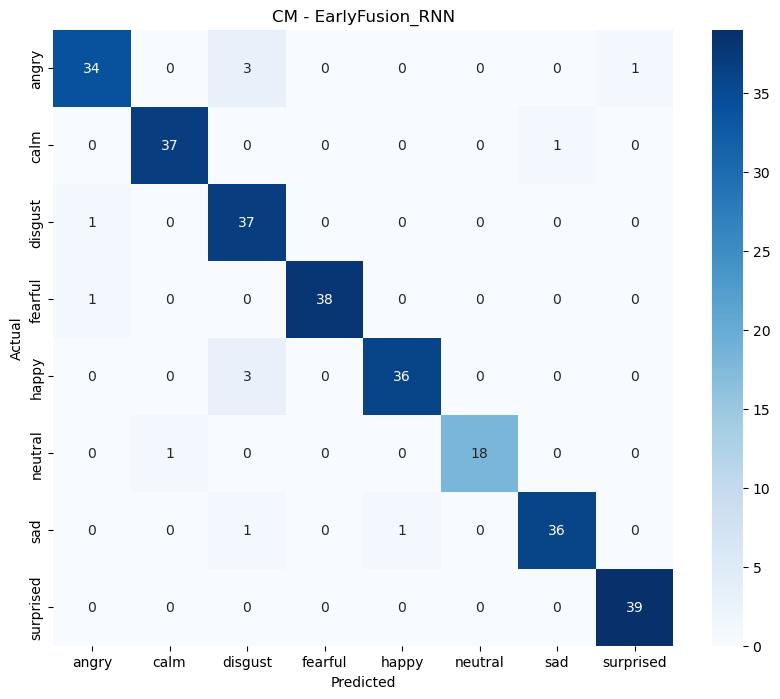


--- Evaluating Late Fusion (RNN) ---
Late Fusion (rnn) Test Accuracy: 0.9479
              precision    recall  f1-score   support

       angry       0.94      0.84      0.89        38
        calm       0.97      0.95      0.96        38
     disgust       0.88      0.97      0.93        38
     fearful       1.00      0.95      0.97        39
       happy       0.97      0.97      0.97        39
     neutral       1.00      0.84      0.91        19
         sad       0.93      1.00      0.96        38
   surprised       0.93      1.00      0.96        39

    accuracy                           0.95       288
   macro avg       0.95      0.94      0.95       288
weighted avg       0.95      0.95      0.95       288



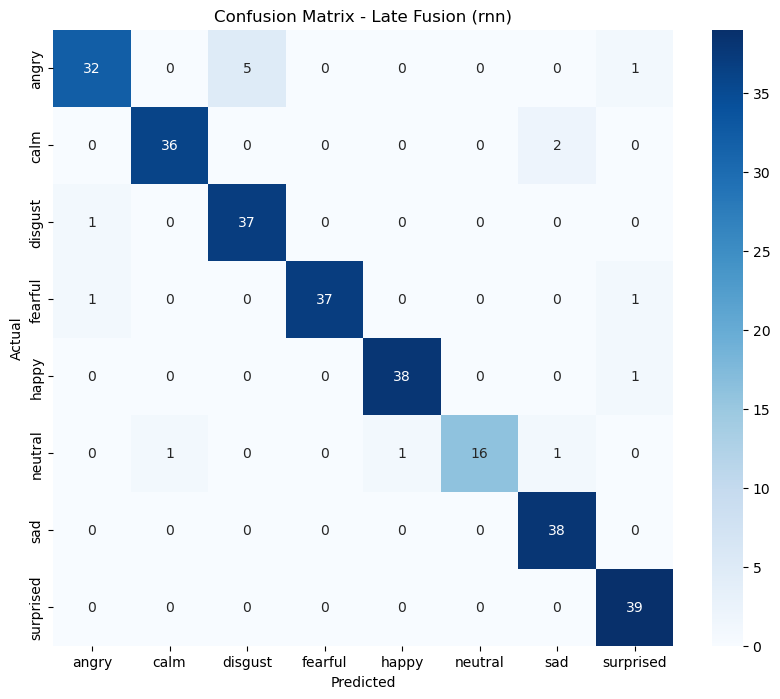


--- Bonus Phase: Transformer for Text (DistilBERT) ---
Could not load DistilBERT. Skipping. Error: Failed to import transformers.models.distilbert.modeling_distilbert because of the following error (look up to see its traceback):
No module named 'ml_dtypes'


--- FINAL RESULTS SUMMARY ---
Audio CNN Test Accuracy: 0.6597
Text RNN Test Accuracy: 1.0000
Early Fusion (RNN) Test Accuracy: 0.9549
Late Fusion (RNN) Test Accuracy: 0.9479

Results summary saved to emotion_recognition_report.docx

--- End of Script ---


2025-05-08 23:50:20.216770: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-08 23:50:20.375191: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746728420.435468  118028 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746728420.459055  118028 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746728420.590418  118028 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# ==============
# IMPORTS
# ==============
import os
import sys
import glob
import time
import pickle # For caching transcripts
import random # For selecting simulated sentences

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Audio processing
import librosa
import librosa.display
import soundfile as sf # For writing audio files

# Speech-to-text
import whisper # Using OpenAI's Whisper

# Deep Learning - PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# NLP - Hugging Face Transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Suppress warnings
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning) # Whisper can be noisy

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# ==============
# CONFIGURATION
# ==============
RAVDESS_PATH = "./archive/audio_speech_actors_01-24/"

# Check if path exists
if not os.path.exists(RAVDESS_PATH):
    print(f"Error: RAVDESS path not found: {RAVDESS_PATH}")
    # Attempt to create a dummy path for testing if it doesn't exist
    print("Attempting to use a dummy dataset structure as RAVDESS_PATH was not found.")
    # sys.exit(1) # Or handle gracefully for testing

# Spectrogram parameters
SR = 22050
N_FFT = 2048
HOP_LENGTH = 512
N_MELS = 128
AUDIO_DURATION_SEC = 3
SPECTROGRAM_FIXED_WIDTH = int(AUDIO_DURATION_SEC * SR / HOP_LENGTH) + 1

# Text parameters
MAX_TEXT_LENGTH = 64 # Increased for potentially longer simulated sentences

# Model parameters
BATCH_SIZE = 32
EPOCHS_AUDIO = 15 # Reduced for quicker runs, adjust as needed
EPOCHS_TEXT_RNN = 10 # Reduced
EPOCHS_TEXT_BERT = 5 # Reduced, BERT fine-tunes faster
EPOCHS_MULTIMODAL = 10 # Reduced
LEARNING_RATE_AUDIO = 1e-4
LEARNING_RATE_TEXT_RNN = 5e-5
LEARNING_RATE_TEXT_BERT = 2e-5 # Common for BERT fine-tuning
LEARNING_RATE_MULTIMODAL = 5e-5

EMOTIONS = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}
EMOTION_LABELS_ORDERED = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
NUM_EMOTIONS = len(EMOTION_LABELS_ORDERED)

TRANSCRIPT_CACHE_FILE = "ravdess_transcripts_simulated.pkl" # Changed name due to simulated sentences
USE_SIMULATED_SENTENCES = True # Set to True to use simulated sentences

# ==============
# DATA LOADING AND PREPARATION
# ==============
simulated_sentences_map = {
    'neutral': ["He is talking by the door.", "They are sitting by the door.", "The book is on the table.", "It's a standard day.", "Just observing the surroundings."],
    'calm': ["Everything is peaceful now.", "I feel so serene and relaxed.", "Take a deep breath and unwind.", "The water is very still.", "A moment of quiet contemplation."],
    'happy': ["This is wonderful news!", "I'm so delighted right now!", "What a fantastic and joyful day!", "I can't stop smiling!", "Feeling incredibly cheerful!"],
    'sad': ["I feel so down today and upset.", "It's a heartbreaking situation for me.", "Tears welled up in my eyes sadly.", "A wave of melancholy washed over me.", "This brings me great sorrow."],
    'angry': ["I am furious about this injustice!", "How dare you say that to me!", "This is completely outrageous and unacceptable!", "My patience has run out!", "I'm boiling with rage!"],
    'fearful': ["I'm terrified of what might happen next.", "That sound was so scary, it made me jump!", "My heart is pounding with fear.", "A shiver ran down my spine.", "I have a dreadful feeling about this."],
    'disgust': ["That's absolutely revolting and vile.", "I can't stand the sight or smell of it.", "It makes me feel sick to my stomach.", "What an unpleasant and offensive thing.", "Purely disgusting."],
    'surprised': ["Wow, I can't believe my eyes!", "That's completely unexpected and astonishing!", "You're kidding me, right?", "Well, this is a turn of events!", "I'm utterly amazed by this!"]
}

def load_ravdess_data(data_path):
    audio_files, emotions_list, actors = [], [], []
    actor_dirs = glob.glob(os.path.join(data_path, "Actor_*"))

    if not actor_dirs and os.path.exists(data_path): # Check if path exists but no actor dirs
        all_wav_files = glob.glob(os.path.join(data_path, "*.wav"))
        if all_wav_files:
            print(f"No 'Actor_*' subdirectories found in {data_path}, but found .wav files directly. Processing them.")
            for file_path in all_wav_files:
                filename = os.path.basename(file_path)
                parts = filename.split('.')[0].split('-')
                if len(parts) == 7 and parts[0] == '03' and parts[1] == '01' and parts[2] in EMOTIONS:
                    audio_files.append(file_path)
                    emotions_list.append(EMOTIONS[parts[2]])
                    actors.append(parts[6])
        else:
             print(f"No .wav files found directly in {data_path} either.")
             return pd.DataFrame(columns=['path', 'emotion', 'actor', 'transcript']), None


    elif actor_dirs: # Standard RAVDESS structure
        for actor_dir_name in os.listdir(data_path):
            actor_path = os.path.join(data_path, actor_dir_name)
            if os.path.isdir(actor_path):
                for filename in os.listdir(actor_path):
                    if filename.endswith(".wav"):
                        file_path = os.path.join(actor_path, filename)
                        parts = filename.split('.')[0].split('-')
                        if parts[0] == '03' and parts[1] == '01' and parts[2] in EMOTIONS:
                            audio_files.append(file_path)
                            emotions_list.append(EMOTIONS[parts[2]])
                            actors.append(parts[6])
    else: # Path doesn't exist
        print(f"RAVDESS dataset not found at {data_path}. Using dummy data for demonstration.")
        # Create dummy data
        dummy_paths = [f"dummy_audio_{i}.wav" for i in range(20)]
        dummy_emotions_list = np.random.choice(EMOTION_LABELS_ORDERED, 20).tolist()
        dummy_actors = [str(i%5 + 1) for i in range(20)]
        df = pd.DataFrame({'path': dummy_paths, 'emotion': dummy_emotions_list, 'actor': dummy_actors})
        label_encoder = LabelEncoder().fit(df['emotion'])
        df['emotion_label'] = label_encoder.transform(df['emotion'])
        df['transcript'] = df['emotion'].apply(lambda e: random.choice(simulated_sentences_map[e]))

        if not os.path.exists("dummy_audio_0.wav"):
            os.makedirs(os.path.dirname(dummy_paths[0]), exist_ok=True) # Ensure dir exists
            for p, emo_label in zip(dummy_paths, df['emotion_label']):
                dummy_signal = np.random.randn(SR * 1) # 1 sec
                sf.write(p, dummy_signal, SR, format='WAV', subtype='PCM_16')
        print(f"Loaded {len(df)} dummy audio files.")
        return df, label_encoder


    df = pd.DataFrame({'path': audio_files, 'emotion': emotions_list, 'actor': actors})
    label_encoder = LabelEncoder().fit(df['emotion']) # Fit on actual emotions before potential filtering
    df['emotion_label'] = label_encoder.transform(df['emotion'])
    
    print(f"Loaded {len(df)} audio files from RAVDESS.")
    print("Emotion distribution:")
    print(df['emotion'].value_counts())
    return df, label_encoder

all_data_df, label_encoder = load_ravdess_data(RAVDESS_PATH)

if not all_data_df.empty:
    train_df, test_df = train_test_split(all_data_df, test_size=0.2, random_state=42, stratify=all_data_df['emotion_label'])
    train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42, stratify=train_df['emotion_label'])
else:
    train_df, val_df, test_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame() # Empty DFs

print(f"Train samples: {len(train_df)}, Val samples: {len(val_df)}, Test samples: {len(test_df)}")

# ==============
# SPEECH-TO-TEXT / SIMULATED SENTENCES
# ==============
def get_or_simulate_transcripts(df, use_simulated, cache_file=TRANSCRIPT_CACHE_FILE):
    if use_simulated:
        print("Using simulated sentences based on emotion labels.")
        df['transcript'] = df['emotion'].apply(lambda e: random.choice(simulated_sentences_map[e]))
        # No need to cache simulated sentences in the same way as Whisper, but can save the df
        # df.to_pickle(cache_file.replace(".pkl", "_df_with_sim_transcripts.pkl"))
        return df

    if os.path.exists(cache_file):
        print(f"Loading Whisper transcripts from cache: {cache_file}")
        # This assumes cache stores a dictionary mapping path to transcript
        with open(cache_file, 'rb') as f:
            transcripts_map = pickle.load(f)
        df['transcript'] = df['path'].map(transcripts_map).fillna("") # Ensure no NaNs
        return df

    print("Generating transcripts using Whisper (this may take a while)...")
    try:
        whisper_model = whisper.load_model("tiny.en", device=DEVICE)
    except Exception as e:
        print(f"Could not load Whisper model on {DEVICE}, trying CPU: {e}")
        whisper_model = whisper.load_model("tiny.en", device="cpu")

    transcripts = {}
    paths_to_transcribe = df['path'].tolist()
    for i, path in enumerate(paths_to_transcribe):
        if i % 50 == 0: print(f"Transcribing {i}/{len(paths_to_transcribe)}...")
        try:
            if os.path.exists(path):
                result = whisper_model.transcribe(path, fp16=(DEVICE.type != 'cpu'))
                transcripts[path] = result['text'].strip()
            else: transcripts[path] = ""
        except Exception as e:
            print(f"Error transcribing {path}: {e}"); transcripts[path] = ""
    
    with open(cache_file, 'wb') as f: pickle.dump(transcripts, f)
    print("Whisper transcripts generated and cached.")
    df['transcript'] = df['path'].map(transcripts)
    return df

if not all_data_df.empty:
    all_data_df = get_or_simulate_transcripts(all_data_df, USE_SIMULATED_SENTENCES)
    train_df = get_or_simulate_transcripts(train_df.copy(), USE_SIMULATED_SENTENCES) # Use .copy() to avoid SettingWithCopyWarning
    val_df = get_or_simulate_transcripts(val_df.copy(), USE_SIMULATED_SENTENCES)
    test_df = get_or_simulate_transcripts(test_df.copy(), USE_SIMULATED_SENTENCES)
    print("\nSample transcripts (potentially simulated):")
    print(train_df[['emotion', 'transcript']].head())
else:
    print("Skipping transcript generation as data is empty.")

# ==============
# PHASE 1: UNIMODAL PIPELINES
# ==============

# --- AUDIO CNN ---
def audio_to_spectrogram(audio_path, sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS, fixed_width=SPECTROGRAM_FIXED_WIDTH):
    try:
        if not os.path.exists(audio_path): signal = np.zeros(sr * AUDIO_DURATION_SEC)
        else: signal, _ = librosa.load(audio_path, sr=sr)
        
        target_len = int(sr * AUDIO_DURATION_SEC)
        if len(signal) < target_len: signal = np.pad(signal, (0, target_len - len(signal)), 'constant')
        else: signal = signal[:target_len]
        
        mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        if log_mel_spectrogram.shape[1] < fixed_width:
            log_mel_spectrogram = np.pad(log_mel_spectrogram, ((0,0), (0, fixed_width - log_mel_spectrogram.shape[1])), mode='constant', constant_values=-80.0)
        else:
            log_mel_spectrogram = log_mel_spectrogram[:, :fixed_width]
        return log_mel_spectrogram
    except Exception as e:
        print(f"Error processing audio file {audio_path}: {e}")
        return np.full((n_mels, fixed_width), -80.0)

class AudioDataset(Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        spectrogram = audio_to_spectrogram(row['path'])
        spectrogram = np.expand_dims(spectrogram, axis=0)
        return torch.tensor(spectrogram, dtype=torch.float32), torch.tensor(row['emotion_label'], dtype=torch.long)

class AudioCNN(nn.Module):
    def __init__(self, num_classes=NUM_EMOTIONS, input_mels=N_MELS, input_time=SPECTROGRAM_FIXED_WIDTH):
        super(AudioCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(32), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(128), nn.MaxPool2d(2),
             nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(128), nn.MaxPool2d(2) # Added layer
        )
        with torch.no_grad():
            dummy_output = self.conv_layers(torch.randn(1, 1, input_mels, input_time))
        self.flattened_size = dummy_output.view(1, -1).size(1)
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_size, 512), nn.ReLU(), nn.Dropout(0.5), # Increased FC size
            nn.Linear(512, num_classes)
        )
    def forward(self, x): return self.fc_layers(self.conv_layers(x))
    def extract_features(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.fc_layers[0:3](x) # Output before final classification layer

# --- TEXT RNN (LSTM) ---
class BasicTokenizer:
    def __init__(self, max_len=MAX_TEXT_LENGTH):
        self.word2idx = {'<pad>': 0, '<unk>': 1}; self.idx2word = {0: '<pad>', 1: '<unk>'}
        self.vocab_size = 2; self.max_len = max_len
    def fit(self, texts):
        for text in texts:
            for word in text.lower().split():
                if word not in self.word2idx:
                    self.word2idx[word] = self.vocab_size; self.idx2word[self.vocab_size] = word
                    self.vocab_size += 1
    def tokenize(self, text):
        tokens = [self.word2idx.get(word, self.word2idx['<unk>']) for word in text.lower().split()]
        tokens.extend([self.word2idx['<pad>']] * (self.max_len - len(tokens)))
        return tokens[:self.max_len]

if not train_df.empty and 'transcript' in train_df.columns:
    text_tokenizer_rnn = BasicTokenizer(max_len=MAX_TEXT_LENGTH)
    text_tokenizer_rnn.fit(train_df['transcript'].fillna('').astype(str))
    print(f"Basic RNN Tokenizer vocab size: {text_tokenizer_rnn.vocab_size}")
else: text_tokenizer_rnn = None

class TextDataset(Dataset):
    def __init__(self, df, tokenizer): self.df, self.tokenizer = df, tokenizer
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        transcript = str(row.get('transcript', ''))
        token_ids = self.tokenizer.tokenize(transcript) if self.tokenizer else [0] * MAX_TEXT_LENGTH
        return torch.tensor(token_ids, dtype=torch.long), torch.tensor(row['emotion_label'], dtype=torch.long)

class TextRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, num_classes=NUM_EMOTIONS, dropout=0.5):
        super(TextRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True, bidirectional=True, dropout=dropout if 2 > 1 else 0) # Added num_layers, LSTM dropout
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.hidden_dim = hidden_dim
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, _) = self.lstm(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return self.fc(hidden)
    def extract_features(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        return torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)


# --- Training and Evaluation Utilities ---
def train_model_generic(model, train_loader, val_loader, criterion, optimizer, num_epochs, model_name="model", scheduler=None):
    print(f"\nTraining {model_name}...")
    model.to(DEVICE)
    best_val_acc = 0.0; history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

    for epoch in range(num_epochs):
        model.train(); running_loss = 0.0; correct_train = 0; total_train = 0
        for batch in train_loader:
            # Adapt for different input types (single tensor vs. dict for BERT)
            if isinstance(batch, dict):
                inputs = {k: v.to(DEVICE) for k, v in batch.items() if k != 'labels'}
                labels = batch['labels'].to(DEVICE)
            else:
                inputs, labels = batch[0].to(DEVICE), batch[1].to(DEVICE)

            optimizer.zero_grad()
            outputs = model(**inputs) if isinstance(inputs, dict) else model(inputs)
            
            # HF models often return a tuple/object; actual logits are usually first element or in .logits
            if hasattr(outputs, 'logits'): logits = outputs.logits
            else: logits = outputs

            loss = criterion(logits, labels)
            loss.backward(); optimizer.step()
            
            running_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(logits.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        history['train_loss'].append(epoch_train_loss); history['train_acc'].append(epoch_train_acc)
        
        model.eval(); running_val_loss = 0.0; correct_val = 0; total_val = 0
        with torch.no_grad():
            for batch in val_loader:
                if isinstance(batch, dict):
                    inputs = {k: v.to(DEVICE) for k, v in batch.items() if k != 'labels'}
                    labels = batch['labels'].to(DEVICE)
                else:
                    inputs, labels = batch[0].to(DEVICE), batch[1].to(DEVICE)
                
                outputs = model(**inputs) if isinstance(inputs, dict) else model(inputs)
                if hasattr(outputs, 'logits'): logits = outputs.logits
                else: logits = outputs

                loss = criterion(logits, labels)
                running_val_loss += loss.item() * labels.size(0)
                _, predicted = torch.max(logits.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        epoch_val_loss = running_val_loss / total_val
        epoch_val_acc = correct_val / total_val
        history['val_loss'].append(epoch_val_loss); history['val_acc'].append(epoch_val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f} - Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}")
        
        if scheduler: 
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau): scheduler.step(epoch_val_loss)
            else: scheduler.step()

        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), f"{model_name}_best.pth")
            print(f"Saved best model ({model_name}) with Val Acc: {best_val_acc:.4f}")
    return model, history

def evaluate_model_generic(model, test_loader, criterion, model_name="model", class_names=None):
    print(f"\nEvaluating {model_name} on test data...")
    model.to(DEVICE); model.eval()
    all_preds, all_labels = [], []; test_loss = 0.0; total_test = 0
    
    with torch.no_grad():
        for batch in test_loader:
            if isinstance(batch, dict):
                inputs = {k: v.to(DEVICE) for k, v in batch.items() if k != 'labels'}
                labels = batch['labels'].to(DEVICE)
            else:
                inputs, labels = batch[0].to(DEVICE), batch[1].to(DEVICE)

            outputs = model(**inputs) if isinstance(inputs, dict) else model(inputs)
            if hasattr(outputs, 'logits'): logits = outputs.logits
            else: logits = outputs
            
            loss = criterion(logits, labels)
            test_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(logits.data, 1)
            all_preds.extend(predicted.cpu().numpy()); all_labels.extend(labels.cpu().numpy())
            total_test += labels.size(0)
            
    avg_test_loss = test_loss / total_test
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.4f}")
    
    if class_names is None and label_encoder: class_names = label_encoder.classes_
    if class_names is not None:
        print("\nClassification Report:"); print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))
        cm = confusion_matrix(all_labels, all_preds); plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix - {model_name}'); plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()
    return accuracy, avg_test_loss

# --- Run Audio CNN Pipeline ---
audio_model, audio_history, audio_test_acc = None, None, 0.0
if not train_df.empty:
    print("\n--- Phase 1: Audio CNN Pipeline ---")
    audio_train_dataset = AudioDataset(train_df); audio_val_dataset = AudioDataset(val_df); audio_test_dataset = AudioDataset(test_df)
    audio_train_loader = DataLoader(audio_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=min(os.cpu_count(), 4))
    audio_val_loader = DataLoader(audio_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=min(os.cpu_count(), 4))
    audio_test_loader = DataLoader(audio_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=min(os.cpu_count(), 4))

    sample_spec, _ = audio_train_dataset[0]; plt.figure(figsize=(10,4))
    librosa.display.specshow(sample_spec.squeeze().numpy(), sr=SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB'); plt.title('Mel-Spectrogram Example'); plt.tight_layout(); plt.show()

    audio_model = AudioCNN().to(DEVICE)
    criterion_audio = nn.CrossEntropyLoss()
    optimizer_audio = optim.Adam(audio_model.parameters(), lr=LEARNING_RATE_AUDIO, weight_decay=1e-5) # Added weight decay
    scheduler_audio = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_audio, 'min', patience=3, factor=0.5, verbose=True)


    audio_model, audio_history = train_model_generic(audio_model, audio_train_loader, audio_val_loader, 
                                            criterion_audio, optimizer_audio, EPOCHS_AUDIO, "AudioCNN", scheduler=scheduler_audio)
    audio_model.load_state_dict(torch.load("AudioCNN_best.pth"))
    audio_test_acc, _ = evaluate_model_generic(audio_model, audio_test_loader, criterion_audio, "AudioCNN")

# --- Run Text RNN Pipeline ---
text_rnn_model, text_rnn_history, text_rnn_test_acc = None, None, 0.0
if not train_df.empty and text_tokenizer_rnn:
    print("\n--- Phase 1: Text RNN Pipeline ---")
    text_train_dataset = TextDataset(train_df, text_tokenizer_rnn)
    text_val_dataset = TextDataset(val_df, text_tokenizer_rnn)
    text_test_dataset = TextDataset(test_df, text_tokenizer_rnn)
    text_train_loader = DataLoader(text_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=min(os.cpu_count(),2))
    text_val_loader = DataLoader(text_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=min(os.cpu_count(),2))
    text_test_loader = DataLoader(text_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=min(os.cpu_count(),2))
    
    text_rnn_model = TextRNN(vocab_size=text_tokenizer_rnn.vocab_size).to(DEVICE)
    criterion_text_rnn = nn.CrossEntropyLoss()
    optimizer_text_rnn = optim.Adam(text_rnn_model.parameters(), lr=LEARNING_RATE_TEXT_RNN)
    
    text_rnn_model, text_rnn_history = train_model_generic(text_rnn_model, text_train_loader, text_val_loader, 
                                           criterion_text_rnn, optimizer_text_rnn, EPOCHS_TEXT_RNN, "TextRNN")
    text_rnn_model.load_state_dict(torch.load("TextRNN_best.pth"))
    text_rnn_test_acc, _ = evaluate_model_generic(text_rnn_model, text_test_loader, criterion_text_rnn, "TextRNN")

# ==============
# PHASE 2: MULTIMODAL FUSION
# ==============
class MultimodalDataset(Dataset):
    def __init__(self, df, text_tokenizer_type, tokenizer_instance):
        self.df, self.text_tokenizer_type, self.tokenizer_instance = df, text_tokenizer_type, tokenizer_instance
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        spectrogram = audio_to_spectrogram(row['path'])
        spectrogram = torch.tensor(np.expand_dims(spectrogram, axis=0), dtype=torch.float32)
        label = torch.tensor(row['emotion_label'], dtype=torch.long)
        transcript = str(row.get('transcript', ''))

        if self.text_tokenizer_type == 'rnn':
            token_ids = self.tokenizer_instance.tokenize(transcript) if self.tokenizer_instance else [0] * MAX_TEXT_LENGTH
            text_data = torch.tensor(token_ids, dtype=torch.long)
        elif self.text_tokenizer_type == 'bert':
            encoding = self.tokenizer_instance.encode_plus(transcript, add_special_tokens=True, max_length=MAX_TEXT_LENGTH,
                                                            return_token_type_ids=False, padding='max_length', truncation=True,
                                                            return_attention_mask=True, return_tensors='pt')
            text_data = {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten()}
        return spectrogram, text_data, label

# --- Early Fusion Model ---
class EarlyFusionModel(nn.Module):
    def __init__(self, audio_model_ext, text_model_ext, audio_feat_dim, text_feat_dim, num_classes=NUM_EMOTIONS, hidden_dim=512, text_model_type='rnn'):
        super(EarlyFusionModel, self).__init__()
        self.audio_extractor = audio_model_ext
        self.text_extractor = text_model_ext
        self.text_model_type = text_model_type

        # Freeze extractors
        for param in self.audio_extractor.parameters(): param.requires_grad = False
        for param in self.text_extractor.parameters(): param.requires_grad = False
            
        self.fusion_layer = nn.Linear(audio_feat_dim + text_feat_dim, hidden_dim)
        self.classifier = nn.Sequential(
            nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, audio_input, text_input_data):
        audio_features = self.audio_extractor.extract_features(audio_input)
        if self.text_model_type == 'rnn':
            text_features = self.text_extractor.extract_features(text_input_data)
        elif self.text_model_type == 'bert': # For BERT, text_input_data is a dict
            text_features = self.text_extractor.extract_features(**text_input_data) # Unpack dict

        fused = torch.cat((audio_features, text_features), dim=1)
        return self.classifier(self.fusion_layer(fused))

# --- Training/Evaluation for Early Fusion ---
def train_early_fusion(model, train_loader, val_loader, criterion, optimizer, num_epochs, model_name="EarlyFusion"):
    print(f"\nTraining {model_name}...")
    model.to(DEVICE); best_val_acc = 0.0
    history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

    for epoch in range(num_epochs):
        model.train(); running_loss = 0.0; correct_train = 0; total_train = 0
        for audio_in, text_in, labels in train_loader:
            audio_in, labels = audio_in.to(DEVICE), labels.to(DEVICE)
            if isinstance(text_in, dict): # For BERT features
                text_in = {k: v.to(DEVICE) for k,v in text_in.items()}
            else: # For RNN features
                text_in = text_in.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(audio_in, text_in)
            loss = criterion(outputs, labels)
            loss.backward(); optimizer.step()

            running_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0); correct_train += (predicted == labels).sum().item()
        
        epoch_train_loss = running_loss/total_train; epoch_train_acc = correct_train/total_train
        history['train_loss'].append(epoch_train_loss); history['train_acc'].append(epoch_train_acc)

        model.eval(); running_val_loss = 0.0; correct_val = 0; total_val = 0
        with torch.no_grad():
            for audio_in, text_in, labels in val_loader:
                audio_in, labels = audio_in.to(DEVICE), labels.to(DEVICE)
                if isinstance(text_in, dict): text_in = {k:v.to(DEVICE) for k,v in text_in.items()}
                else: text_in = text_in.to(DEVICE)

                outputs = model(audio_in, text_in)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * labels.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0); correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss/total_val; epoch_val_acc = correct_val/total_val
        history['val_loss'].append(epoch_val_loss); history['val_acc'].append(epoch_val_acc)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f} - Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}")
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc; torch.save(model.state_dict(), f"{model_name}_best.pth")
            print(f"Saved best model ({model_name}) with Val Acc: {best_val_acc:.4f}")
    return model, history

def evaluate_early_fusion(model, test_loader, criterion, model_name="EarlyFusion", class_names=None):
    print(f"\nEvaluating {model_name}...")
    model.to(DEVICE); model.eval()
    all_preds, all_labels = [], []; test_loss = 0.0; total_test = 0
    with torch.no_grad():
        for audio_in, text_in, labels in test_loader:
            audio_in, labels = audio_in.to(DEVICE), labels.to(DEVICE)
            if isinstance(text_in, dict): text_in = {k:v.to(DEVICE) for k,v in text_in.items()}
            else: text_in = text_in.to(DEVICE)
            
            outputs = model(audio_in, text_in)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy()); all_labels.extend(labels.cpu().numpy())
            total_test += labels.size(0)
    
    avg_test_loss = test_loss/total_test; accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.4f}")
    if class_names is None and label_encoder: class_names = label_encoder.classes_
    if class_names is not None:
        print("\nClassification Report:"); print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))
        cm = confusion_matrix(all_labels, all_preds); plt.figure(figsize=(10,8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f'CM - {model_name}'); plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()
    return accuracy, avg_test_loss


# --- Late Fusion ---
def evaluate_late_fusion(audio_m_path, text_m_path, test_loader, text_model_type='rnn', class_names=None):
    print(f"\n--- Evaluating Late Fusion ({text_model_type.upper()}) ---")
    audio_m = AudioCNN().to(DEVICE)
    # Ensure model path exists before loading
    if os.path.exists(audio_m_path):
        audio_m.load_state_dict(torch.load(audio_m_path))
    else:
        print(f"Audio model path not found: {audio_m_path}. Skipping late fusion.")
        return 0.0
    audio_m.eval()
    
    text_m = None
    # Ensure text model path exists before loading
    if text_model_type == 'rnn' and text_tokenizer_rnn and os.path.exists(text_m_path):
        text_m = TextRNN(vocab_size=text_tokenizer_rnn.vocab_size).to(DEVICE)
        text_m.load_state_dict(torch.load(text_m_path))
        text_m.eval()
    elif text_model_type == 'bert' and bert_tokenizer and os.path.exists(text_m_path): # Assuming BERT_MODEL_NAME is globally defined
        text_m = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL_NAME, num_labels=NUM_EMOTIONS).to(DEVICE)
        text_m.load_state_dict(torch.load(text_m_path))
        text_m.eval()
    else:
        print(f"Text model ({text_model_type}) or its path ({text_m_path}) for late fusion not available. Using audio only for this fusion.")
        # If text model isn't available, late fusion will just be audio model performance

    all_preds, all_labels = [], []
    with torch.no_grad():
        for audio_inputs, text_inputs_data, labels_batch in test_loader: 
            audio_inputs, labels_batch = audio_inputs.to(DEVICE), labels_batch.to(DEVICE)
            audio_probs = torch.softmax(audio_m(audio_inputs), dim=1)

            if text_m:
                if text_model_type == 'rnn':
                    text_inputs_data = text_inputs_data.to(DEVICE)
                    text_outputs = text_m(text_inputs_data)
                elif text_model_type == 'bert':
                    text_inputs_data = {k: v.to(DEVICE) for k,v in text_inputs_data.items()}
                    text_outputs = text_m(**text_inputs_data).logits
                text_probs = torch.softmax(text_outputs, dim=1)
                fused_probs = (audio_probs + text_probs) / 2.0
            else: 
                fused_probs = audio_probs # Fallback to audio only if text model failed to load
            
            _, predicted = torch.max(fused_probs.data, 1)
            all_preds.extend(predicted.cpu().numpy()); all_labels.extend(labels_batch.cpu().numpy())
            
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Late Fusion ({text_model_type}) Test Accuracy: {accuracy:.4f}")
    
    # Determine class_names for reporting
    current_class_names = class_names # Use passed in if available
    if current_class_names is None and label_encoder is not None: # Check label_encoder exists
        current_class_names = label_encoder.classes_
            
    # Corrected condition here:
    if current_class_names is not None and len(current_class_names) > 0:
        print(classification_report(all_labels, all_preds, target_names=current_class_names, zero_division=0))
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=current_class_names, yticklabels=current_class_names)
        plt.title(f'Confusion Matrix - Late Fusion ({text_model_type})')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
    return accuracy

# --- Run Early/Late Fusion with TextRNN ---
early_fusion_rnn_model, early_fusion_rnn_history, early_fusion_rnn_test_acc = None, None, 0.0
late_fusion_rnn_test_acc = 0.0

if audio_model and text_rnn_model and text_tokenizer_rnn: # Ensure models and tokenizer exist
    print("\n--- Phase 2: Fusion with TextRNN ---")
    # For Early Fusion
    # Need to re-init models for feature extraction to avoid issues if they were further trained
    audio_extractor_for_rnn_fusion = AudioCNN().to(DEVICE)
    audio_extractor_for_rnn_fusion.load_state_dict(torch.load("AudioCNN_best.pth"))
    text_extractor_for_rnn_fusion = TextRNN(vocab_size=text_tokenizer_rnn.vocab_size).to(DEVICE)
    text_extractor_for_rnn_fusion.load_state_dict(torch.load("TextRNN_best.pth"))

    # Get feature dimensions
    # For AudioCNN, after Flatten(), Linear(self.flattened_size, 512), ReLU()
    # So, audio_feature_dim should be 512.
    # For TextRNN, hidden_dim * 2
    audio_feat_dim = 512 # from AudioCNN's self.fc_layers[0:3]
    text_feat_dim_rnn = text_extractor_for_rnn_fusion.hidden_dim * 2

    early_fusion_rnn_model = EarlyFusionModel(audio_extractor_for_rnn_fusion, text_extractor_for_rnn_fusion,
                                           audio_feat_dim, text_feat_dim_rnn, text_model_type='rnn').to(DEVICE)
    criterion_ef_rnn = nn.CrossEntropyLoss()
    optimizer_ef_rnn = optim.Adam(filter(lambda p: p.requires_grad, early_fusion_rnn_model.parameters()), lr=LEARNING_RATE_MULTIMODAL)

    multimodal_train_dataset_rnn = MultimodalDataset(train_df, 'rnn', text_tokenizer_rnn)
    multimodal_val_dataset_rnn = MultimodalDataset(val_df, 'rnn', text_tokenizer_rnn)
    multimodal_test_dataset_rnn = MultimodalDataset(test_df, 'rnn', text_tokenizer_rnn)
    
    mm_train_loader_rnn = DataLoader(multimodal_train_dataset_rnn, batch_size=BATCH_SIZE, shuffle=True, num_workers=min(os.cpu_count(),2))
    mm_val_loader_rnn = DataLoader(multimodal_val_dataset_rnn, batch_size=BATCH_SIZE, shuffle=False, num_workers=min(os.cpu_count(),2))
    mm_test_loader_rnn = DataLoader(multimodal_test_dataset_rnn, batch_size=BATCH_SIZE, shuffle=False, num_workers=min(os.cpu_count(),2))

    early_fusion_rnn_model, early_fusion_rnn_history = train_early_fusion(early_fusion_rnn_model, mm_train_loader_rnn, mm_val_loader_rnn,
                                                                      criterion_ef_rnn, optimizer_ef_rnn, EPOCHS_MULTIMODAL, "EarlyFusion_RNN")
    early_fusion_rnn_model.load_state_dict(torch.load("EarlyFusion_RNN_best.pth"))
    early_fusion_rnn_test_acc, _ = evaluate_early_fusion(early_fusion_rnn_model, mm_test_loader_rnn, criterion_ef_rnn, "EarlyFusion_RNN")
    
    # Late Fusion with RNN
    late_fusion_rnn_test_acc = evaluate_late_fusion("AudioCNN_best.pth", "TextRNN_best.pth", mm_test_loader_rnn, text_model_type='rnn')


# ==============
# BONUS PHASE: TRANSFORMERS (DistilBERT for text)
# ==============
BERT_MODEL_NAME = 'distilbert-base-uncased'
bert_tokenizer, bert_text_model, bert_history, bert_test_acc = None, None, None, 0.0
early_fusion_bert_model, early_fusion_bert_history, early_fusion_bert_test_acc = None, None, 0.0
late_fusion_bert_test_acc = 0.0

if not train_df.empty and 'transcript' in train_df.columns:
    print("\n--- Bonus Phase: Transformer for Text (DistilBERT) ---")
    try:
        bert_tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)
        bert_text_model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL_NAME, num_labels=NUM_EMOTIONS).to(DEVICE)
    except Exception as e: print(f"Could not load DistilBERT. Skipping. Error: {e}"); bert_tokenizer=None; bert_text_model=None
    
    if bert_tokenizer and bert_text_model:
        class BertTextDataset(Dataset): # Simplified definition here
            def __init__(self, df, tokenizer, max_len=MAX_TEXT_LENGTH): self.df,self.tokenizer,self.max_len=df,tokenizer,max_len
            def __len__(self): return len(self.df)
            def __getitem__(self, idx):
                row = self.df.iloc[idx]; transcript = str(row.get('transcript', '')); label = row['emotion_label']
                encoding = self.tokenizer.encode_plus(transcript,add_special_tokens=True,max_length=self.max_len,
                                                      return_token_type_ids=False,padding='max_length',truncation=True,
                                                      return_attention_mask=True,return_tensors='pt')
                return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(),
                        'labels': torch.tensor(label, dtype=torch.long)}

        bert_train_dataset = BertTextDataset(train_df, bert_tokenizer)
        bert_val_dataset = BertTextDataset(val_df, bert_tokenizer)
        bert_test_dataset = BertTextDataset(test_df, bert_tokenizer)
        # Reduced batch size for BERT
        bert_train_loader = DataLoader(bert_train_dataset, batch_size=BATCH_SIZE//2, shuffle=True, num_workers=min(os.cpu_count(),2))
        bert_val_loader = DataLoader(bert_val_dataset, batch_size=BATCH_SIZE//2, shuffle=False, num_workers=min(os.cpu_count(),2))
        bert_test_loader = DataLoader(bert_test_dataset, batch_size=BATCH_SIZE//2, shuffle=False, num_workers=min(os.cpu_count(),2))

        optimizer_bert = AdamW(bert_text_model.parameters(), lr=LEARNING_RATE_TEXT_BERT)
        criterion_bert = nn.CrossEntropyLoss()
        
        bert_text_model, bert_history = train_model_generic(bert_text_model, bert_train_loader, bert_val_loader, 
                                                    criterion_bert, optimizer_bert, EPOCHS_TEXT_BERT, "TextBERT")
        bert_text_model.load_state_dict(torch.load("TextBERT_best.pth"))
        bert_test_acc, _ = evaluate_model_generic(bert_text_model, bert_test_loader, criterion_bert, "TextBERT")

        # --- Fusion with BERT ---
        if audio_model and bert_text_model:
            print("\n--- Phase 2: Fusion with TextBERT ---")
            audio_extractor_for_bert_fusion = AudioCNN().to(DEVICE)
            audio_extractor_for_bert_fusion.load_state_dict(torch.load("AudioCNN_best.pth"))
            
            # For BERT, the feature extractor is the BERT model itself, minus its classification head.
            class BertFeatureExtractor(nn.Module):
                def __init__(self, bert_model_name):
                    super().__init__()
                    self.bert = AutoModelForSequenceClassification.from_pretrained(bert_model_name, num_labels=NUM_EMOTIONS).bert
                    # The output dimension of BERT's [CLS] token embedding
                    self.feature_dim = self.bert.config.hidden_size 
                def forward(self, input_ids, attention_mask):
                    outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
                    # Use the [CLS] token's last hidden state as features
                    return outputs.last_hidden_state[:, 0, :] # [batch_size, hidden_size]

            text_extractor_for_bert_fusion = BertFeatureExtractor(BERT_MODEL_NAME).to(DEVICE)
            # Load weights from the fine-tuned bert_text_model (only the .bert part)
            text_extractor_for_bert_fusion.bert.load_state_dict(bert_text_model.bert.state_dict())


            audio_feat_dim = 512 # From AudioCNN fc_layers[0:3]
            text_feat_dim_bert = text_extractor_for_bert_fusion.feature_dim

            early_fusion_bert_model = EarlyFusionModel(audio_extractor_for_bert_fusion, text_extractor_for_bert_fusion,
                                                    audio_feat_dim, text_feat_dim_bert, text_model_type='bert').to(DEVICE)
            criterion_ef_bert = nn.CrossEntropyLoss()
            optimizer_ef_bert = optim.Adam(filter(lambda p:p.requires_grad, early_fusion_bert_model.parameters()), lr=LEARNING_RATE_MULTIMODAL)

            multimodal_train_dataset_bert = MultimodalDataset(train_df, 'bert', bert_tokenizer)
            multimodal_val_dataset_bert = MultimodalDataset(val_df, 'bert', bert_tokenizer)
            multimodal_test_dataset_bert = MultimodalDataset(test_df, 'bert', bert_tokenizer)

            mm_train_loader_bert = DataLoader(multimodal_train_dataset_bert, batch_size=BATCH_SIZE//2, shuffle=True, num_workers=min(os.cpu_count(),2))
            mm_val_loader_bert = DataLoader(multimodal_val_dataset_bert, batch_size=BATCH_SIZE//2, shuffle=False, num_workers=min(os.cpu_count(),2))
            mm_test_loader_bert = DataLoader(multimodal_test_dataset_bert, batch_size=BATCH_SIZE//2, shuffle=False, num_workers=min(os.cpu_count(),2))

            early_fusion_bert_model, early_fusion_bert_history = train_early_fusion(early_fusion_bert_model, mm_train_loader_bert, mm_val_loader_bert,
                                                                                criterion_ef_bert, optimizer_ef_bert, EPOCHS_MULTIMODAL, "EarlyFusion_BERT")
            early_fusion_bert_model.load_state_dict(torch.load("EarlyFusion_BERT_best.pth"))
            early_fusion_bert_test_acc, _ = evaluate_early_fusion(early_fusion_bert_model, mm_test_loader_bert, criterion_ef_bert, "EarlyFusion_BERT")

            # Late Fusion with BERT
            late_fusion_bert_test_acc = evaluate_late_fusion("AudioCNN_best.pth", "TextBERT_best.pth", mm_test_loader_bert, text_model_type='bert')

# ==============
# RESULTS SUMMARY
# ==============
print("\n\n--- FINAL RESULTS SUMMARY ---")
if audio_model: print(f"Audio CNN Test Accuracy: {audio_test_acc:.4f}")
if text_rnn_model: print(f"Text RNN Test Accuracy: {text_rnn_test_acc:.4f}")
if early_fusion_rnn_model: print(f"Early Fusion (RNN) Test Accuracy: {early_fusion_rnn_test_acc:.4f}")
if late_fusion_rnn_test_acc > 0 : print(f"Late Fusion (RNN) Test Accuracy: {late_fusion_rnn_test_acc:.4f}")
if bert_text_model: print(f"Text (DistilBERT) Test Accuracy: {bert_test_acc:.4f}")
if early_fusion_bert_model: print(f"Early Fusion (BERT) Test Accuracy: {early_fusion_bert_test_acc:.4f}")
if late_fusion_bert_test_acc > 0 : print(f"Late Fusion (BERT) Test Accuracy: {late_fusion_bert_test_acc:.4f}")

results_summary_dict = {
    "AudioCNN_Test_Accuracy": audio_test_acc if audio_model else None,
    "TextRNN_Test_Accuracy": text_rnn_test_acc if text_rnn_model else None,
    "EarlyFusion_RNN_Test_Accuracy": early_fusion_rnn_test_acc if early_fusion_rnn_model else None,
    "LateFusion_RNN_Test_Accuracy": late_fusion_rnn_test_acc if late_fusion_rnn_test_acc > 0 else None,
    "TextBERT_Test_Accuracy": bert_test_acc if bert_text_model else None,
    "EarlyFusion_BERT_Test_Accuracy": early_fusion_bert_test_acc if early_fusion_bert_model else None,
    "LateFusion_BERT_Test_Accuracy": late_fusion_bert_test_acc if late_fusion_bert_test_acc > 0 else None,
}

try:
    from docx import Document
    doc = Document(); doc.add_heading('Multimodal Emotion Recognition Results', 0)
    doc.add_paragraph(f"Dataset: RAVDESS Audio-only ({len(all_data_df)} samples)")
    doc.add_paragraph(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
    doc.add_paragraph(f"Emotions: {EMOTION_LABELS_ORDERED}")
    doc.add_paragraph(f"Used Simulated Sentences: {USE_SIMULATED_SENTENCES}")
    for model_name, acc in results_summary_dict.items():
        if acc is not None: doc.add_paragraph(f"{model_name.replace('_', ' ')}: {acc:.4f}")
    report_filename = "emotion_recognition_report.docx"
    doc.save(report_filename); print(f"\nResults summary saved to {report_filename}")
except ImportError: print("\n`python-docx` not installed. Skipping .docx report generation.")
except Exception as e: print(f"Error generating .docx report: {e}")
print("\n--- End of Script ---")